In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_excel('/content/drive/MyDrive/PosTech/Fase4/Tech Cha/base_petroleo.xlsx')
df.head()


,data,preco_bruto_Brent_FOB
0,2024-12-31,74.58
1,2024-12-30,74.24
2,2024-12-27,73.77
3,2024-12-26,73.50
4,2024-12-24,73.50


In [ ]:
df = pd.DataFrame({
    "data": df['data'],
    "valor": df['preco_bruto_Brent_FOB']
})

In [ ]:
df_mensal = df.groupby(df["data"].dt.to_period("M")).agg({"valor": "mean"}).reset_index()
df_mensal.rename(columns={"data": "mes", "valor": "mean_mensal"}, inplace=True)

In [ ]:
df_mensal.head()

,mes,mean_mensal
0,2004-01,31.266000
1,2004-02,30.648621
2,2004-03,33.663226
3,2004-04,33.346667
4,2004-05,37.294839


In [ ]:
df_anual = df.groupby(df["data"].dt.to_period("Y")).agg({"valor": "mean"}).reset_index()
df_anual.rename(columns={"data": "ano", "valor": "media_anual"}, inplace=True)

In [ ]:
df_anual.head()

,ano,media_anual
0,2004,38.162000
1,2005,54.325879
2,2006,65.116951
3,2007,72.030279
4,2008,97.531791


In [ ]:
df['data'] = pd.to_datetime(df["data"])
df.dtypes

,0
data,datetime64[ns]
valor,float64


In [ ]:
!pip install xgboost
!pip install pmdarima
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error

)
from statsmodels.tsa.seasonal import seasonal_decompose

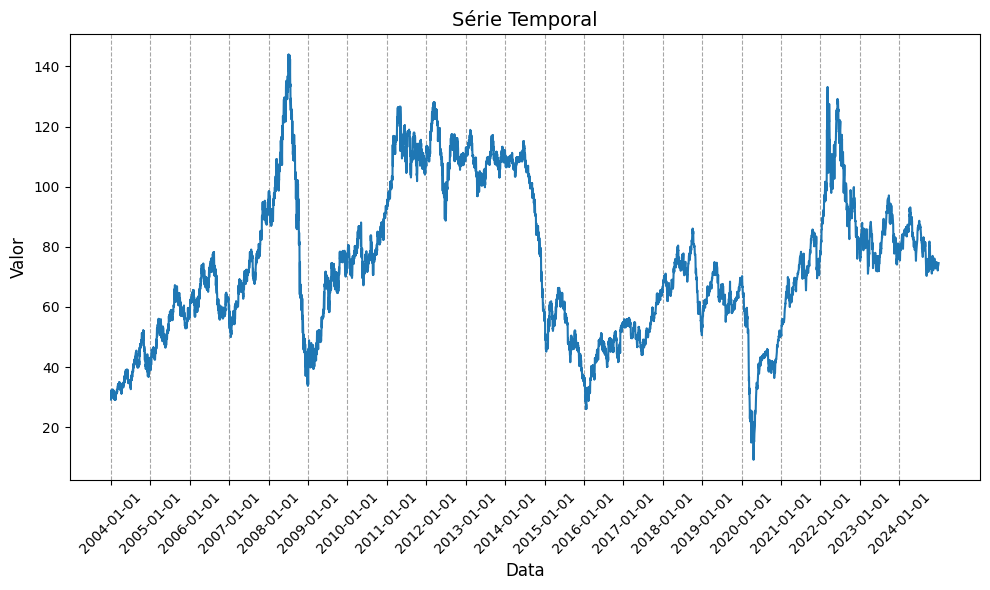

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['data'], df['valor'], linestyle='-')
plt.title('Série Temporal', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.grid(True, which='major', axis='x', linestyle='--', color='gray', alpha=0.7)
plt.xticks(pd.date_range(start='2004-01-01', end='2024-12-31', freq='YS'), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
result = seasonal_decompose(df['valor'], model='multiplicative', period=365)

<Axes: >

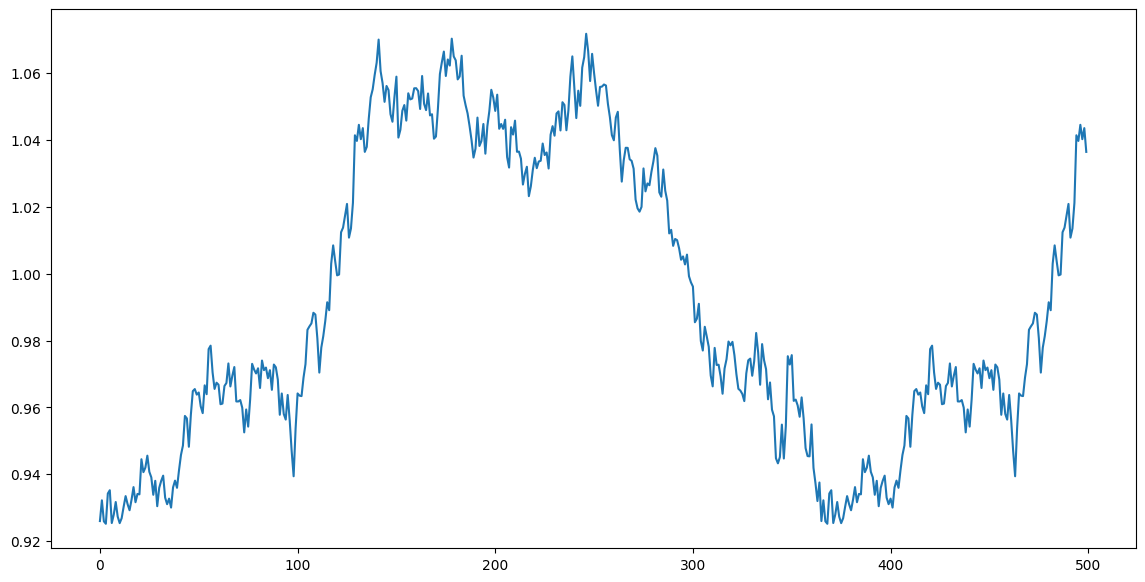

In [ ]:
result.seasonal.iloc[:500].plot(figsize=(14,7))

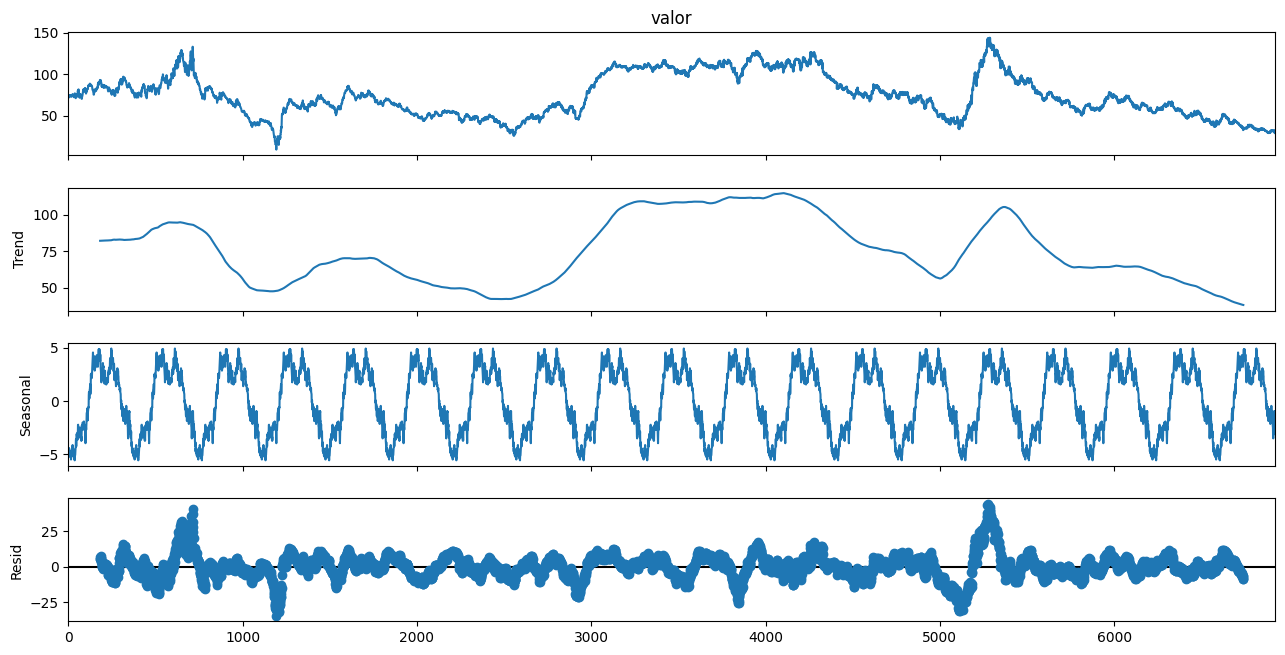

In [ ]:
result = seasonal_decompose(df['valor'], model='additive', period=365)
fig = result.plot()
fig.set_size_inches(14,7)

In [ ]:
adf_result = sm.tsa.adfuller(df['valor'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.03:
  print("A série temporal é estacionária")
else:
  print("A série temporal não é estacionária")

ADF Statistic: -2.323673786906212
p-value: 0.1644463345229094
Critical Values: {'1%': -3.431299178358933, '5%': -2.8619594595441695, '10%': -2.566993274459373}
A série temporal não é estacionária


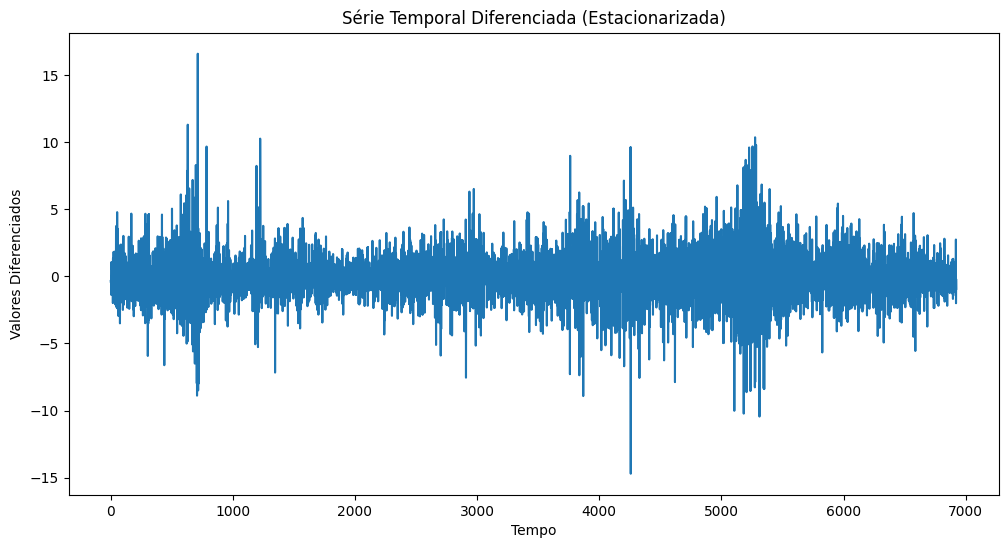

In [ ]:
df.loc[:, 'Diferenciado'] = df['valor'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df['Diferenciado'])
plt.title('Série Temporal Diferenciada (Estacionarizada)')
plt.xlabel('Tempo')
plt.ylabel('Valores Diferenciados')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Diferenciado'].dropna())

print(f"Valor-p: {result[1]}")

if result[1] < 0.05:
    print("A série diferenciada é estacionária (Rejeitamos H0).")
else:
    print("A série diferenciada ainda não é estacionária (Não rejeitamos H0).")

Valor-p: 4.103626896169343e-25
A série diferenciada é estacionária (Rejeitamos H0).


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf

<Figure size 1200x600 with 0 Axes>

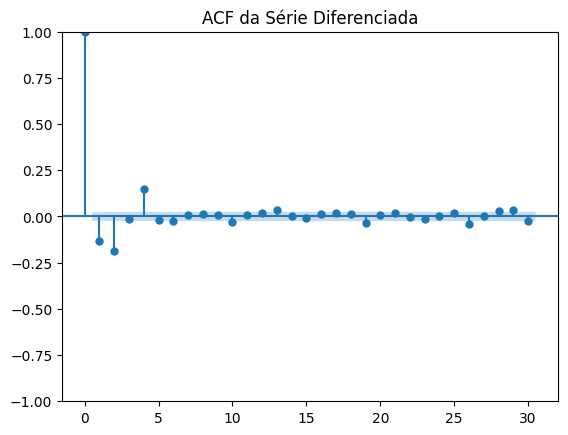

In [ ]:
plt.figure(figsize=(12, 6))
_plot_acf(df['Diferenciado'].dropna(), lags=30)
plt.title('ACF da Série Diferenciada')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf

<Figure size 1200x600 with 0 Axes>

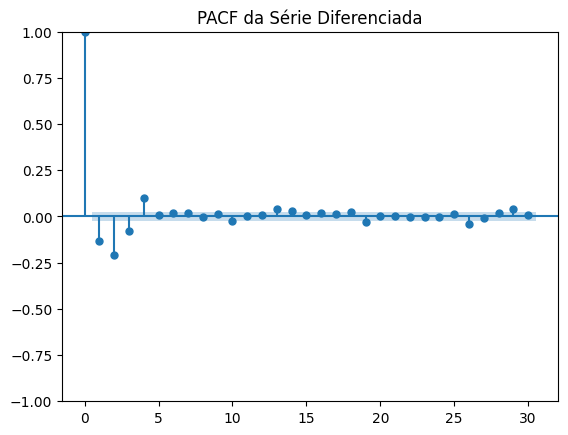

In [ ]:
plt.figure(figsize=(12, 6))
_plot_pacf(df['Diferenciado'].dropna(), lags=30)
plt.title('PACF da Série Diferenciada')
plt.show()

In [ ]:
df_petroleo = df
df_petroleo = df_petroleo.sort_values(by='data', ascending=True)

train_size = len(df_petroleo) - 253
train, test = df_petroleo[:train_size], df_petroleo[train_size:]


def create_features(df_f):
  df_f["Data"] = pd.to_datetime(df_f["data"])
  df_f["year"] = df_f["data"].dt.year
  df_f['month'] = df_f["data"].dt.month
  df_f["day"] = df_f["data"].dt.day
  df_f["dayofweek"] = df_f["data"].dt.dayofweek
  return df_f

train = create_features(train)
test = create_features(test)

FEATURES =["year", "month", "day", "dayofweek", "valor"]
TARGET = "valor"

<ipython-input-61-270600dead9a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f["Data"] = pd.to_datetime(df_f["data"])
<ipython-input-61-270600dead9a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f["year"] = df_f["data"].dt.year
<ipython-input-61-270600dead9a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

# Modelo XGBoost

In [ ]:
x_train, y_train = train[FEATURES], train[TARGET]
x_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective = "reg:squarederror")
reg.fit(x_train, y_train)

preds_xgb = reg.predict(x_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "MAPE": mape}

metrics_xgb = calculate_metrics(y_test, preds_xgb)
MAPE_xgb = metrics_xgb["MAPE"]
print("XGBoost Metrics:")
print(metrics_xgb)
print(f"Acurácia de {100 - (MAPE_xgb * 100): .2f}%")

XGBoost Metrics:
{'MSE': 0.0215680855477578, 'MAE': 0.11790816235448008, 'MAPE': 0.0014514363083647718}
Acurácia de  99.85%


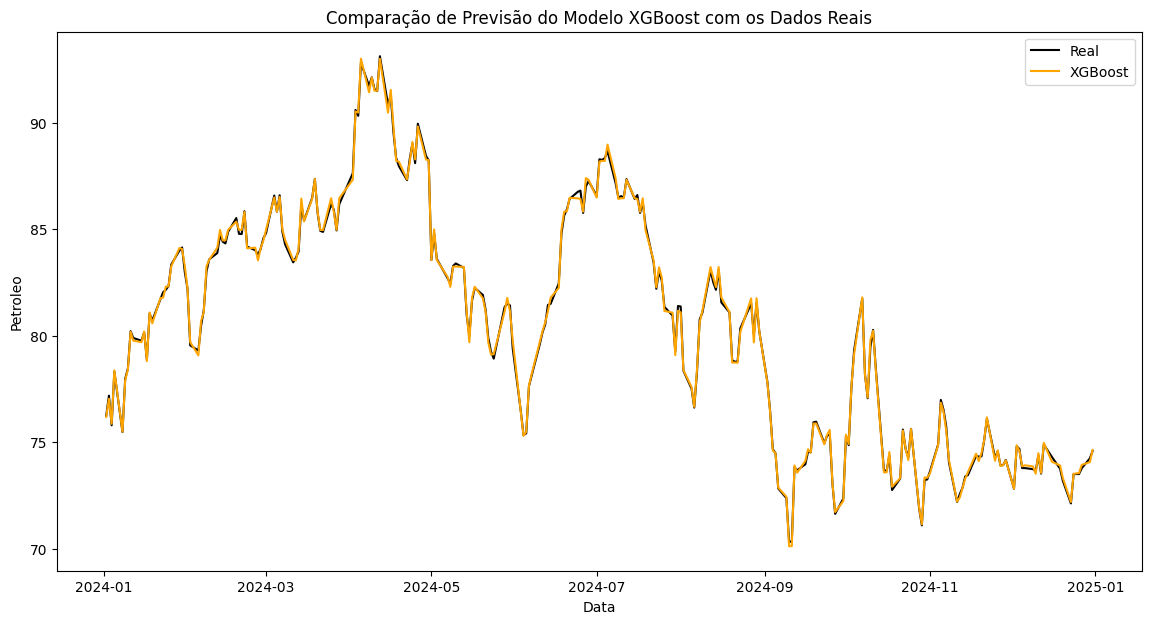

In [ ]:
xgboost_results = pd.DataFrame({'Data': test['Data'], 'Previsão': preds_xgb})

plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['valor'], label='Real', color='black')

plt.plot(xgboost_results['Data'], xgboost_results['Previsão'], label='XGBoost', color='orange')

plt.title('Comparação de Previsão do Modelo XGBoost com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Petroleo')
plt.legend()
plt.show()

# Modelo Prophet

In [ ]:
train_prophet = train.rename(columns={"Data": "ds", "valor": "y"})
train_prophet["valor"] = train["valor"]

test_prophet = test.rename(columns={"Data": "ds", "valor": "y"})
test_prophet["valor"] = test["valor"]

model = Prophet(daily_seasonality=True)
model.add_regressor("valor")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["valor"] = pd.concat([train["valor"], test["valor"]], ignore_index=True)
forecast = model.predict(future)

preds_pr = forecast[["ds", "yhat"]].tail(len(test))
preds_pr = preds_pr.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds_pr["yhat"])
MAPE_pr = metrics_pr["MAPE"]
print("Prophet Metrics")
print(metrics_pr)
print(f"Acurácia de {100 - (MAPE_pr * 100): .2f}%")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp81z9k3e4/fr3rzrll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp81z9k3e4/oibn6jr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61316', 'data', 'file=/tmp/tmp81z9k3e4/fr3rzrll.json', 'init=/tmp/tmp81z9k3e4/oibn6jr0.json', 'output', 'file=/tmp/tmp81z9k3e4/prophet_model8ax24uli/prophet_model-20250121212521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Metrics
{'MSE': 2.0015375285994108e-08, 'MAE': 0.00011513103704194569, 'MAPE': 1.3971415405673548e-06}
Acurácia de  100.00%


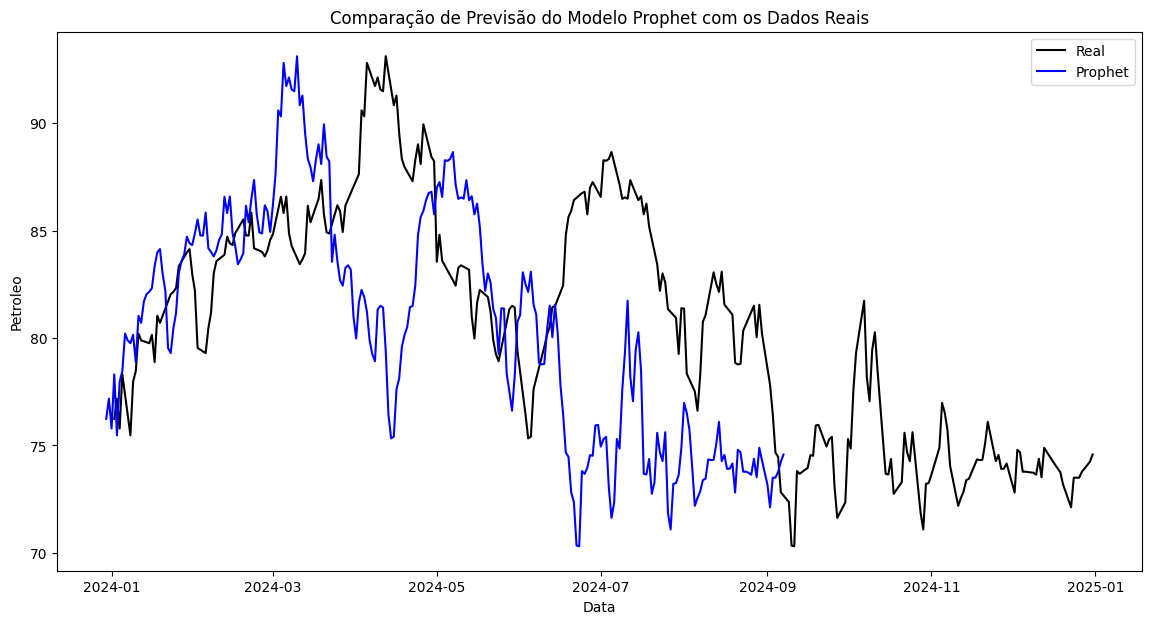

In [ ]:
prophet_results = preds_pr.reset_index()

plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['valor'], label='Real', color='black')

plt.plot(prophet_results['ds'], prophet_results['yhat'], label='Prophet', color='blue')

plt.title('Comparação de Previsão do Modelo Prophet com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Petroleo')
plt.legend()
plt.show()

# Seleção de parâmetros para modelos SARIMAX

In [ ]:
model = pm.auto_arima(
    df['valor'].dropna(),
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True
)

print(model.summary())

seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6924
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -13638.699
Date:                Tue, 21 Jan 2025   AIC                          27291.397
Time:                        21:45:18   BIC                          27339.296
Sample:                             0   HQIC                         27307.911
                               - 6924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7700      0.027     28.243      0.000       0.717       0.823
ar.L2         -0.0404      0.011     -3.551      0.000      -0.063      -0.018
ar.L3          0.1312      0.010     12.575      0.0

In [ ]:
exog_train = train[["valor"]]
exog_test = test[["valor"]]

model = sm.tsa.statespace.SARIMAX(
    train["valor"],
    exog=exog_train,
    order=(
        5,
        1,
        1,
    ),
    seasonal_order=(0, 0, 0, 12),
)
result = model.fit()

preds_sarimax = result.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["valor"], preds_sarimax)
MAPE_sarimax = metrics_sarimax["MAPE"]
print("SARIMAX Metrics")
print(metrics_sarimax)
print(f"Acurácia de {100 - (MAPE_sarimax * 100): .2f}%")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Metrics
{'MSE': 2.806584369445139e-10, 'MAE': 1.4248263756610728e-05, 'MAPE': 1.731439681454872e-07}
Acurácia de  100.00%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


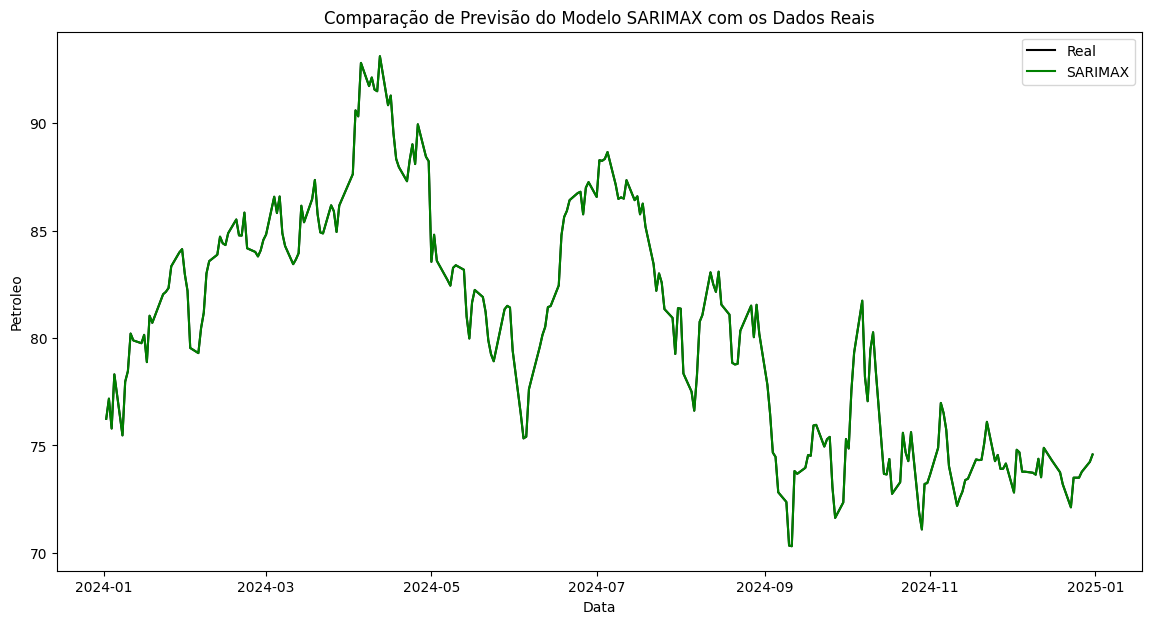

In [ ]:
sarimax_results = pd.DataFrame({
    'Data': pd.to_datetime(test['Data']),
    'Previsão': preds_sarimax.values
})

plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['valor'], label='Real', color='black')

plt.plot(sarimax_results['Data'], sarimax_results['Previsão'], label='SARIMAX', color='green')

plt.title('Comparação de Previsão do Modelo SARIMAX com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Petroleo')
plt.legend()
plt.show()

# Comparando os modelos

In [ ]:
df_modelos = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)

df_modelos["Acurácia%"] = (100 - (df_modelos["MAPE"] * 100)).map('{:,.2f}'.format)

df_modelos.sort_values(by="Acurácia%", ascending=False)

,MAE,MSE,MAPE,Acurácia%
XGBoost,0.117908,2.156809e-02,1.451436e-03,99.85
Prophet,0.000115,2.001538e-08,1.397142e-06,100.00
SARIMAX,0.000014,2.806584e-10,1.731440e-07,100.00


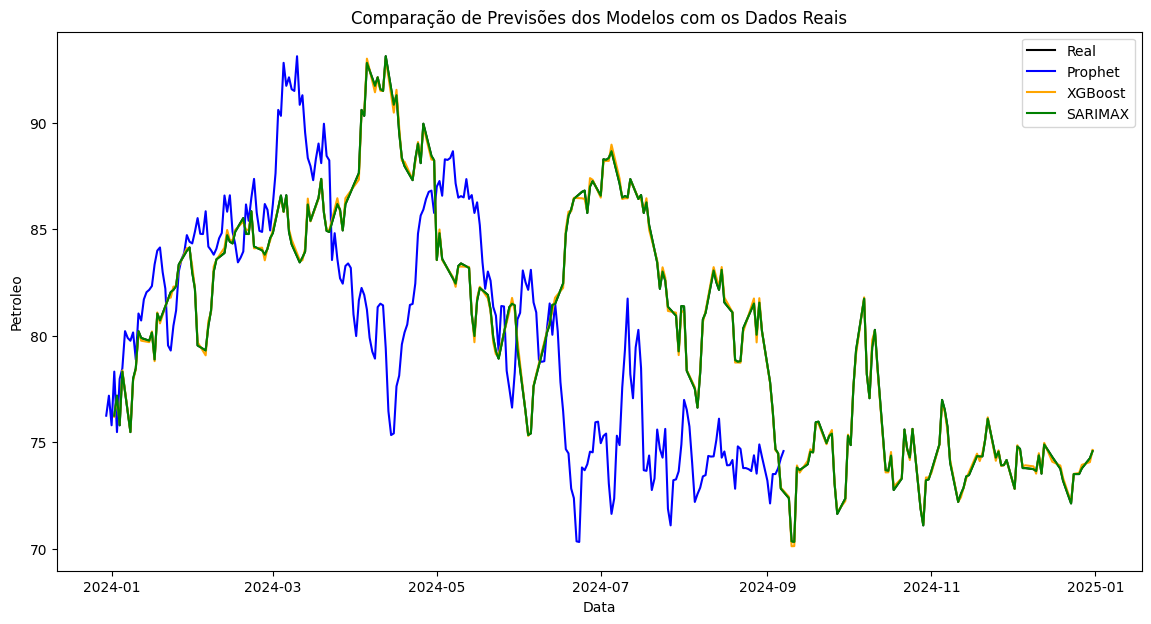

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['valor'], label='Real', color='black')

plt.plot(prophet_results['ds'], prophet_results['yhat'], label='Prophet', color='blue')

plt.plot(xgboost_results['Data'], xgboost_results['Previsão'], label='XGBoost', color='orange')

plt.plot(sarimax_results['Data'], sarimax_results['Previsão'], label='SARIMAX', color='green')

plt.title('Comparação de Previsões dos Modelos com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Petroleo')
plt.legend()
plt.show()